# **Predictive Modeling**

### Lucía Poyan, Nuria Olmedilla y Claudia Gemeno

This notebook focuses on training and evaluating several classification models, ranging from logistic regression to advanced algorithms such as XGBoost and CatBoost. It also includes techniques for class balancing and hyperparameter optimization to maximize model performance.

### **Import libraries**

In [13]:
import pandas as pd
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from collections import Counter
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.tree import plot_tree
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, classification_report, make_scorer, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from scipy.stats import uniform
from sklearn.decomposition import PCA 
import joblib

### **Data Loading**

In [14]:
X_train_selected = pd.read_csv(r"../content/X_train_selected.csv")
X_test_selected = pd.read_csv(r"../content/X_test_selected.csv")

X_train_pca = pd.read_csv(r"../content/X_train_pca.csv")
X_test_pca = pd.read_csv(r"../content/X_test_pca.csv")

y_train_balanced = pd.read_csv(r"../content/y_train_balanced.csv")
y_test = pd.read_csv(r"../content/y_test.csv")


In [15]:
# Set the random seed for reproducibility
seed = 42


The models we've decided to test are:

1. Logistic Regression (Base Model): A simple model used for binary classification, predicting probabilities of class membership.
Random Forest: An ensemble of decision trees that improves accuracy by averaging multiple tree predictions.
2. XGBoost: A gradient boosting algorithm known for its speed and performance, often used in structured/tabular data.
3. LightGBM: A gradient boosting framework that focuses on efficiency and scalability, optimized for large datasets.
4. GLM (Generalized Linear Model): A flexible framework for modeling various types of outcomes, extending linear regression to more complex distributions.
5. CatBoost: A gradient boosting algorithm that handles categorical features efficiently, improving performance with less preprocessing.

Despite applying SMOTE to balance the data, the model still struggles with predicting the minority class (1). The imbalance remains an issue, as the model tends to favor the majority class (0), leading to lower performance in correctly identifying class 1 instances. 

### **Base Model - Logistic Regression**

In [16]:
model = LogisticRegression(random_state=seed)
model.fit(X_train_pca, y_train_balanced)

y_pred = model.predict(X_test_pca)
y_pred_proba = model.predict_proba(X_test_pca)[:, 1]  

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba) 
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Accuracy: 0.7606
ROC AUC: 0.7113
Recall: 0.4784
Precision: 0.1633
F1-Score: 0.2435

Classification Report:

              precision    recall  f1-score   support

           0     0.9450    0.7853    0.8578     15344
           1     0.1633    0.4784    0.2435      1344

    accuracy                         0.7606     16688
   macro avg     0.5542    0.6319    0.5507     16688
weighted avg     0.8821    0.7606    0.8083     16688



The logistic regression model performs well on predicting the majority class (0) but struggles with the minority class (1). While accuracy is decent (76%), the model has low precision and F1-score for class 1, indicating many false positives and missed positive cases. The ROC AUC score suggests some ability to distinguish between the classes, but overall, the model has room for improvement, especially with imbalanced data.

### **RANDOM FOREST**

In [17]:
rf_model = RandomForestClassifier(random_state=seed, class_weight='balanced') 
rf_model.fit(X_train_pca, y_train_balanced)

rf_pred = rf_model.predict(X_test_pca)
rf_pred_proba = rf_model.predict_proba(X_test_pca)[:, 1]  

# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_roc_auc = roc_auc_score(y_test, rf_pred_proba) 
rf_recall = recall_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

# Print metrics
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Random Forest ROC AUC: {rf_roc_auc:.4f}")
print(f"Random Forest Recall: {rf_recall:.4f}")
print(f"Random Forest Precision: {rf_precision:.4f}")
print(f"Random Forest F1-Score: {rf_f1:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, rf_pred, digits=4))


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Random Forest Accuracy: 0.9076
Random Forest ROC AUC: 0.6834
Random Forest Recall: 0.0722
Random Forest Precision: 0.2474
Random Forest F1-Score: 0.1118

Classification Report:

              precision    recall  f1-score   support

           0     0.9235    0.9808    0.9513     15344
           1     0.2474    0.0722    0.1118      1344

    accuracy                         0.9076     16688
   macro avg     0.5855    0.5265    0.5315     16688
weighted avg     0.8690    0.9076    0.8837     16688



For the Random Forest model, we see that while the accuracy is high (0.9076), it still struggles with predicting the minority class (1). The recall for class 1 is very low (0.0722), meaning it misses most of the true positive instances of class 1. Precision for class 1 is higher (0.2474), but the F1-score remains low (0.1118), indicating poor performance in identifying class 1 accurately. This suggests that, despite the overall accuracy, the model is still biased toward predicting the majority class (0) due to the imbalance in the data.

### **XGBOOST**

In [18]:
xgb_model = xgb.XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss') 
xgb_model.fit(X_train_pca, y_train_balanced)

xgb_pred = xgb_model.predict(X_test_pca)
xgb_pred_proba = xgb_model.predict_proba(X_test_pca)[:, 1]  

# Evaluate the model
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_pred_proba)
xgb_recall = recall_score(y_test, xgb_pred)
xgb_precision = precision_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)

# Print metrics
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
print(f"XGBoost ROC AUC: {xgb_roc_auc:.4f}")
print(f"XGBoost Recall: {xgb_recall:.4f}")
print(f"XGBoost Precision: {xgb_precision:.4f}")
print(f"XGBoost F1-score: {xgb_f1:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, xgb_pred, digits=4))


[12:08:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



XGBoost Accuracy: 0.8747
XGBoost ROC AUC: 0.5951
XGBoost Recall: 0.1220
XGBoost Precision: 0.1526
XGBoost F1-score: 0.1356

Classification Report:

              precision    recall  f1-score   support

           0     0.9244    0.9406    0.9325     15344
           1     0.1526    0.1220    0.1356      1344

    accuracy                         0.8747     16688
   macro avg     0.5385    0.5313    0.5340     16688
weighted avg     0.8623    0.8747    0.8683     16688



For the XGBoost model, although the accuracy is decent (0.8747), the model again struggles with the minority class (1). The recall for class 1 is low (0.1220), indicating that it misses a significant number of true positives for this class. The precision (0.1526) is also low, leading to a low F1-score (0.1356), showing that the model is not effectively identifying class 1. Similar to Random Forest, the imbalance in the data significantly affects the performance on the minority class.

### **LIGHTGBM**


In [19]:
lgb_model = lgb.LGBMClassifier(random_state=seed, class_weight='balanced')  
lgb_model.fit(X_train_pca, y_train_balanced)

lgb_pred = lgb_model.predict(X_test_pca)
lgb_pred_proba = lgb_model.predict_proba(X_test_pca)[:, 1] 

# Evaluate the model
lgb_accuracy = accuracy_score(y_test, lgb_pred)
lgb_roc_auc = roc_auc_score(y_test, lgb_pred_proba)
lgb_recall = recall_score(y_test, lgb_pred)
lgb_precision = precision_score(y_test, lgb_pred)
lgb_f1 = f1_score(y_test, lgb_pred)

# Print metrics
print(f"LightGBM Accuracy: {lgb_accuracy:.4f}")
print(f"LightGBM ROC AUC: {lgb_roc_auc:.4f}")
print(f"LightGBM Recall: {lgb_recall:.4f}")
print(f"LightGBM Precision: {lgb_precision:.4f}")
print(f"LightGBM F1-Score: {lgb_f1:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, lgb_pred, digits=4))


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Number of positive: 61375, number of negative: 61375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31875
[LightGBM] [Info] Number of data points in the train set: 122750, number of used features: 125
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Accuracy: 0.8517
LightGBM ROC AUC: 0.5962
LightGBM Recall: 0.1920
LightGBM Precision: 0.1566
LightGBM F1-Score: 0.1725

Classification Report:

              precision    recall  f1-score   support

           0     0.9278    0.9095    0.9185     15344
           1     0.1566    0.1920    0.1725      1344

    accuracy                         0.8517     16688
   macro avg     0.5422    0.5507    0.5455     16688
weighted avg     0.8657    0.8517    0.8585     16688



For the LightGBM model, the accuracy is 0.8517, but similar to the other models, it struggles with predicting the minority class (1). The recall for class 1 is 0.1920, meaning the model identifies a small portion of the true positives in this class. Precision is also low (0.1566), which contributes to a low F1-score (0.1725). Despite the relatively high accuracy and good performance on class 0, the imbalance in the dataset still impacts the model's ability to effectively classify the minority class.

### **GLM**


In [20]:
glm_model = LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=seed)
glm_model.fit(X_train_pca, y_train_balanced)

glm_pred = glm_model.predict(X_test_pca)
glm_pred_proba = glm_model.predict_proba(X_test_pca)[:, 1]  

# Evaluate the model
glm_accuracy = accuracy_score(y_test, glm_pred)
glm_roc_auc = roc_auc_score(y_test, glm_pred_proba)  
glm_precision = precision_score(y_test, glm_pred)
glm_recall = recall_score(y_test, glm_pred)
glm_f1 = f1_score(y_test, glm_pred)

# Print metrics
print(f"GLM Accuracy: {glm_accuracy:.4f}")
print(f"GLM ROC AUC: {glm_roc_auc:.4f}")
print(f"GLM Precision: {glm_precision:.4f}")
print(f"GLM Recall: {glm_recall:.4f}")
print(f"GLM F1-score: {glm_f1:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, glm_pred, digits=4))


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GLM Accuracy: 0.7606
GLM ROC AUC: 0.7113
GLM Precision: 0.1633
GLM Recall: 0.4784
GLM F1-score: 0.2435

Classification Report:

              precision    recall  f1-score   support

           0     0.9450    0.7853    0.8578     15344
           1     0.1633    0.4784    0.2435      1344

    accuracy                         0.7606     16688
   macro avg     0.5542    0.6319    0.5507     16688
weighted avg     0.8821    0.7606    0.8083     16688



The GLM model shows an accuracy of 0.7606, which is decent. It performs reasonably well on class 0 (the majority class) but still struggles with class 1 (the minority class), as indicated by the low precision (0.1633) and F1-score (0.2435) for class 1. However, compared to other models, it seems to be one of the better performing ones for balancing both classes, as it achieves a recall of 0.4784 for class 1. Despite the challenges with the imbalance, GLM currently appears to be the most balanced model so far in terms of handling both classes.

### **CATBOOST**

In [21]:
catboost_model = CatBoostClassifier(random_state=seed, class_weights=[1, 10], verbose=0)
catboost_model.fit(X_train_pca, y_train_balanced)

catboost_pred = catboost_model.predict(X_test_pca)
catboost_pred_proba = catboost_model.predict_proba(X_test_pca)[:, 1]

# Evaluate the model
catboost_accuracy = accuracy_score(y_test, catboost_pred)
catboost_roc_auc = roc_auc_score(y_test, catboost_pred_proba)
catboost_precision = precision_score(y_test, catboost_pred)
catboost_recall = recall_score(y_test, catboost_pred)
catboost_f1 = f1_score(y_test, catboost_pred)

# Print metrics
print(f"CatBoost Accuracy: {catboost_accuracy:.4f}")
print(f"CatBoost ROC AUC: {catboost_roc_auc:.4f}")
print(f"CatBoost Precision: {catboost_precision:.4f}")
print(f"CatBoost Recall: {catboost_recall:.4f}")
print(f"CatBoost F1-score: {catboost_f1:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, catboost_pred, digits=4))


CatBoost Accuracy: 0.7454
CatBoost ROC AUC: 0.6121
CatBoost Precision: 0.1236
CatBoost Recall: 0.3549
CatBoost F1-score: 0.1834

Classification Report:

              precision    recall  f1-score   support

           0     0.9324    0.7797    0.8492     15344
           1     0.1236    0.3549    0.1834      1344

    accuracy                         0.7454     16688
   macro avg     0.5280    0.5673    0.5163     16688
weighted avg     0.8673    0.7454    0.7956     16688



The CatBoost model shows an accuracy of 0.7454, which is lower than other models like Random Forest and Logistic Regression. However, it still provides a reasonable performance on class 1, with a recall of 0.3549, which is better than some of the other models. The precision (0.1236) and F1-score (0.1834) for class 1 are still low, indicating that the model struggles with the minority class.

### **SVM**

In [ ]:
# Sample size
sample_size = 15000

# Generate random indices
np.random.seed(seed)
train_indices = np.random.choice(X_train_pca.shape[0], sample_size, replace=False)
test_indices = np.random.choice(X_test_pca.shape[0], sample_size, replace=False)

# Subset the data
X_train_sample = X_train_pca[train_indices]
y_train_sample = y_train_balanced[train_indices]
X_test_sample = X_test_pca[test_indices]
y_test_sample = y_test[test_indices]

# SVM Model
svm_model = SVC(kernel='linear', class_weight='balanced', random_state=seed, probability=True)
svm_model.fit(X_train_sample, y_train_sample)

# Predictions
svm_pred = svm_model.predict(X_test_sample)
svm_pred_proba = svm_model.predict_proba(X_test_sample)[:, 1]

# Evaluate the model
svm_accuracy = accuracy_score(y_test_sample, svm_pred)
svm_roc_auc = roc_auc_score(y_test_sample, svm_pred_proba)
svm_precision = precision_score(y_test_sample, svm_pred)
svm_recall = recall_score(y_test_sample, svm_pred)
svm_f1 = f1_score(y_test_sample, svm_pred)

# Print metrics
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"SVM ROC AUC: {svm_roc_auc:.4f}")
print(f"SVM Precision: {svm_precision:.4f}")
print(f"SVM Recall: {svm_recall:.4f}")
print(f"SVM F1-score: {svm_f1:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test_sample, svm_pred, digits=4))



SVM Accuracy: 0.7700
SVM ROC AUC: 0.6928
SVM Precision: 0.1537
SVM Recall: 0.4133
SVM F1-score: 0.2240

Classification Report:

              precision    recall  f1-score   support

           0     0.9399    0.8012    0.8650     13795
           1     0.1537    0.4133    0.2240      1205

    accuracy                         0.7700     15000
   macro avg     0.5468    0.6072    0.5445     15000
weighted avg     0.8767    0.7700    0.8135     15000



We decided to test the Support Vector Machine (SVM) model to see how it performs with our data. The SVM is a classification algorithm that seeks to find the best hyperplane to separate the classes in the feature space. Since we are working with a very large dataset, the training time could be extensive, which would make it difficult to conduct tests and tune hyperparameters.

For this reason, to conduct an initial test and observe the results more quickly, we chose to use a smaller subset of data, with 15,000 samples instead of the full dataset. Although the results obtained with this sample may seem promising, we must keep in mind that we cannot delve into hyperparameter optimization or conduct an exhaustive evaluation of the model due to the reduced size of the data.

This approach allowed us to get a preliminary view of the model's performance, but it is not sufficient to fine-tune the model or generalize the results to the entire dataset.

Finally, we have chosen two models—Logistic Regression and GLM—as they have the best metrics. These models will undergo hyperparameter optimization to further improve their performance. However, it’s important to note that these selections are temporary, and after optimization, we will evaluate them again to decide which model will be the final choice.

## **Hyperparameter Optimization**

### **Test with Randomized Search (Logistic Regression)**

In [ ]:
# Base model
model = LogisticRegression(random_state=seed, solver='saga')

# Search space
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': uniform(0.01, 10),  
    'l1_ratio': uniform(0.1, 0.9),  
    'class_weight': [None, 'balanced'],
    'max_iter': [100, 500, 1000]
}

# RandomizedSearchCV configuration
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=50,  # Try 50 random combinations
    scoring='f1',  # Optimize F1-Score
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=seed
)

random_search.fit(X_train_pca, y_train_balanced)

# Best combination of hyperparameters
best_params = random_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Evaluate the optimized model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_pca)
y_pred_proba = best_model.predict_proba(X_test_pca)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'C': 3.687831327192532, 'class_weight': 'balanced', 'l1_ratio': 0.9850808268053587, 'max_iter': 500, 'penalty': 'elasticnet'}
Accuracy: 0.7607
ROC AUC: 0.7113
Recall: 0.4784
Precision: 0.1634
F1-Score: 0.2436

Classification Report:

              precision    recall  f1-score   support

           0     0.9450    0.7855    0.8579     15344
           1     0.1634    0.4784    0.2436      1344

    accuracy                         0.7607     16688
   macro avg     0.5542    0.6319    0.5507     16688
weighted avg     0.8821    0.7607    0.8084     16688



Hyperparameter optimization for logistic regression was conducted using Randomized Search with 50 random parameter combinations and 5-fold cross-validation. The best hyperparameters included a C value of 3.69, elasticnet regularization, balanced class weights, an l1_ratio of 0.99, and a maximum of 500 iterations.

Despite optimization, model performance metrics showed minimal improvement. Overall accuracy increased marginally from 0.7606 to 0.7607, and the F1-score for the minority class slightly improved from 0.2435 to 0.2436. Other metrics, such as ROC AUC (0.7113) and recall for the minority class (0.4784), remained unchanged. Grid Search was attempted but could not be executed due to computational constraints.

In conclusion, the optimization confirmed that the initial parameters were close to a local optimum. However, the primary limitation lies in the class imbalance, which restricts the model's ability to improve minority class predictions.

### **Test with Grid Search (GLM with Logistic Regression)**

In [ ]:
glm_base = LogisticRegression(solver='lbfgs', random_state=seed)

# Define hyperparameters for GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'max_iter': [100, 200, 500],   
    'class_weight': [
        'balanced',
        {0: 0.7, 1: 0.3},
        {0: 0.6, 1: 0.4},
        {0: 0.5, 1: 0.5}
    ]
}

scorer = make_scorer(roc_auc_score, needs_proba=True)

# Configure GridSearchCV
grid_search = GridSearchCV(
    estimator=glm_base,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,  
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_pca, y_train_balanced)

# Get the best hyperparameters and metrics
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Evaluate the model with the best hyperparameters
glm_optimized = grid_search.best_estimator_
glm_pred = glm_optimized.predict(X_test_pca)
glm_pred_proba = glm_optimized.predict_proba(X_test_pca)[:, 1]

# Calculate metrics
glm_accuracy = accuracy_score(y_test, glm_pred)
glm_roc_auc = roc_auc_score(y_test, glm_pred_proba)
glm_precision = precision_score(y_test, glm_pred)
glm_recall = recall_score(y_test, glm_pred)
glm_f1 = f1_score(y_test, glm_pred)

# Print metrics
print(f"GLM Optimized Accuracy: {glm_accuracy:.4f}")
print(f"GLM Optimized ROC AUC: {glm_roc_auc:.4f}")
print(f"GLM Optimized Precision: {glm_precision:.4f}")
print(f"GLM Optimized Recall: {glm_recall:.4f}")
print(f"GLM Optimized F1-score: {glm_f1:.4f}")

# Print the full classification report
print("\nClassification Report:\n")
print(classification_report(y_test, glm_pred, digits=4))


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best hyperparameters: {'C': 100, 'class_weight': {0: 0.5, 1: 0.5}, 'max_iter': 100}
GLM Optimized Accuracy: 0.7605
GLM Optimized ROC AUC: 0.7113
GLM Optimized Precision: 0.1633
GLM Optimized Recall: 0.4784
GLM Optimized F1-score: 0.2435

Classification Report:

              precision    recall  f1-score   support

           0     0.9450    0.7853    0.8578     15344
           1     0.1633    0.4784    0.2435      1344

    accuracy                         0.7605     16688
   macro avg     0.5542    0.6318    0.5506     16688
weighted avg     0.8821    0.7605    0.8083     16688



### **Test with Randomized Search (GLM with Logistic Regression)**

In [ ]:
# # TEST WITH RANDOMIZED SEARCH (GLM with Logistic Regression)

glm_base = LogisticRegression(solver='lbfgs', random_state=seed)

# Define the search space for RandomizedSearchCV
param_distributions = {
    'C': uniform(0.01, 100),  
    'max_iter': [100, 200, 500, 1000], 
    'class_weight': [
        'balanced',
        {0: 0.7, 1: 0.3},
        {0: 0.6, 1: 0.4},
        {0: 0.5, 1: 0.5}
    ]
}

scorer = make_scorer(roc_auc_score, needs_proba=True)

random_search = RandomizedSearchCV(
    estimator=glm_base,
    param_distributions=param_distributions,
    n_iter=50,  
    scoring=scorer,
    cv=5,  
    n_jobs=-1, 
    verbose=2,
    random_state=seed
)

random_search.fit(X_train_pca, y_train_balanced)

# Get the best hyperparameters and metrics
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)

# Evaluate the model with the best hyperparameters
glm_optimized = random_search.best_estimator_
glm_pred = glm_optimized.predict(X_test_pca)
glm_pred_proba = glm_optimized.predict_proba(X_test_pca)[:, 1]

# Calculate metrics
glm_accuracy = accuracy_score(y_test, glm_pred)
glm_roc_auc = roc_auc_score(y_test, glm_pred_proba)
glm_precision = precision_score(y_test, glm_pred)
glm_recall = recall_score(y_test, glm_pred)
glm_f1 = f1_score(y_test, glm_pred)

# Print metrics
print(f"GLM Optimized Accuracy: {glm_accuracy:.4f}")
print(f"GLM Optimized ROC AUC: {glm_roc_auc:.4f}")
print(f"GLM Optimized Precision: {glm_precision:.4f}")
print(f"GLM Optimized Recall: {glm_recall:.4f}")
print(f"GLM Optimized F1-score: {glm_f1:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, glm_pred, digits=4))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'C': 6.515159298527951, 'class_weight': {0: 0.5, 1: 0.5}, 'max_iter': 100}
GLM Optimized Accuracy: 0.7605
GLM Optimized ROC AUC: 0.7113
GLM Optimized Precision: 0.1632
GLM Optimized Recall: 0.4784
GLM Optimized F1-score: 0.2434

Classification Report:

              precision    recall  f1-score   support

           0     0.9450    0.7852    0.8577     15344
           1     0.1632    0.4784    0.2434      1344

    accuracy                         0.7605     16688
   macro avg     0.5541    0.6318    0.5506     16688
weighted avg     0.8821    0.7605    0.8082     16688



In the hyperparameter optimization process, two main methods were used: Grid Search and Randomized Search, to tune key model parameters such as C, class_weight, and max_iter. Both methods resulted in almost identical outcomes to the unoptimized model, indicating that changes in the hyperparameters had no significant impact.

Grid Search performs an exhaustive search by evaluating all possible combinations within a defined space. In this case, it found the best parameters as C=100, class_weight={0: 0.5, 1: 0.5}, and max_iter=100. However, metrics such as accuracy, ROC AUC, precision, recall, and F1-score showed no differences compared to the initial model. This happens because the model was already tuned for optimal performance with its default configuration, and changes in C were not significant enough to alter its behavior.

Randomized Search, in contrast, selects random combinations of hyperparameters within the same defined space, evaluating a subset of the possibilities. This technique suggested the best configuration as C=6.51, class_weight={0: 0.5, 1: 0.5}, and max_iter=100, but no improvements were observed in the metrics either. This reinforces the idea that the model does not strongly rely on fine-tuning these parameters, and that the data, along with its representation, dominate its performance.

In summary, both methods confirmed that the GLM model had already achieved a consistent level of performance from the start, and adjustments to the hyperparameters did not bring improvements due to the inherent stability of the model and the predominant influence of the data.

Finally, we have decided that our best model, as can be seen from the metrics, is the GLM. Therefore, we will proceed with the final modeling, explainability, and other next steps.

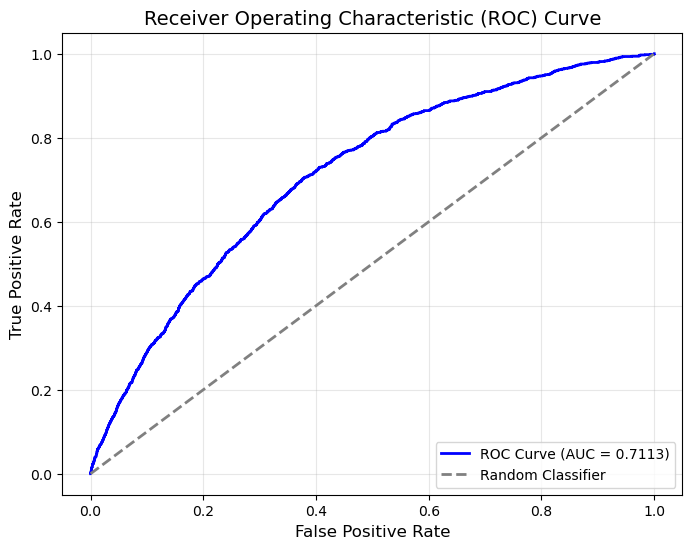

In [ ]:
# Calculate the values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, glm_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label="Random Classifier")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.show()


**ROC Curve (Receiver Operating Characteristic):**

The ROC curve shows the relationship between the True Positive Rate and the False Positive Rate for different decision thresholds.

Interpretation:
- **AUC (Area Under the Curve):** In this case, the AUC is 0.7113, which indicates that the model has a moderate ability to distinguish between positive and negative classes (with 1.0 being ideal and 0.5 equivalent to a random classifier).
- **Diagonal line (random classifier):** Represents the performance of a classifier that makes random decisions. Your model (blue curve) performs better than this line, indicating better than random performance.

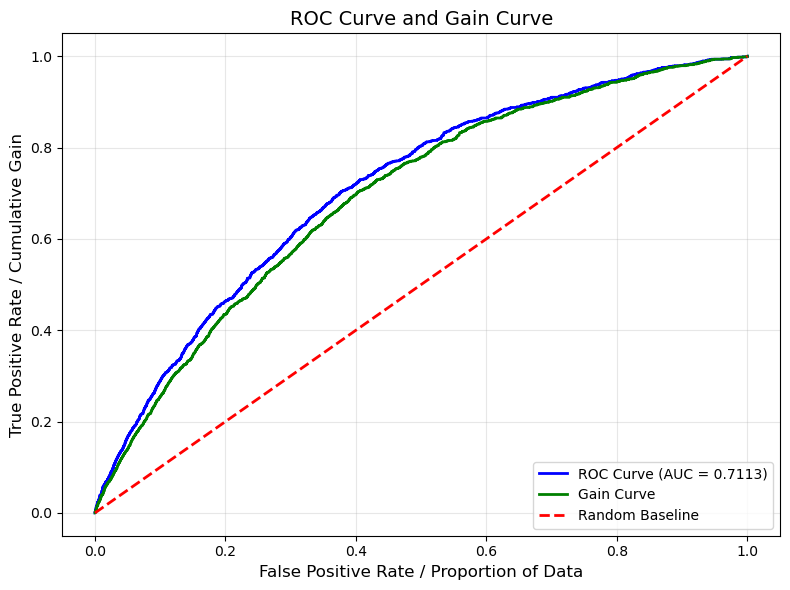

In [ ]:
# Gain Curve
sorted_indices = np.argsort(glm_pred_proba)[::-1] 
sorted_y_test = y_test.iloc[sorted_indices] 

# Calculate the cumulative gain
cumulative_gain = np.cumsum(sorted_y_test) 
total_positives = np.sum(sorted_y_test) 
cumulative_gain = cumulative_gain / total_positives  

random_gain = np.arange(1, len(sorted_y_test) + 1) / len(sorted_y_test) 

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot(np.arange(1, len(sorted_y_test) + 1) / len(sorted_y_test), cumulative_gain, label="Gain Curve", color='green', linewidth=2)
plt.plot(np.arange(1, len(sorted_y_test) + 1) / len(sorted_y_test), random_gain, label="Random Baseline", linestyle="--", color='red', linewidth=2)
plt.xlabel("False Positive Rate / Proportion of Data", fontsize=12)
plt.ylabel("True Positive Rate / Cumulative Gain", fontsize=12)
plt.title("ROC Curve and Gain Curve", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**ROC Curve Combined with Gain Curve:**

This graph combines the ROC curve with a gain curve, which shows the cumulative proportion of positive data identified by the model as more data is included (according to the classification threshold).

Interpretation:
- **The ROC curve (blue)** shows the same information as the previous graph.
- **The Gain Curve (green)** reflects how the model correctly prioritizes positive predictions when using a subset of data classified as positive. However, the gain curve is slightly below the ROC curve, indicating that the model's ability to prioritize positive cases is not as strong as indicated by the ROC curve, resulting in a slightly lower performance in capturing positive instances.

- **The red line (random baseline)** serves as a reference for a model with no predictive power.

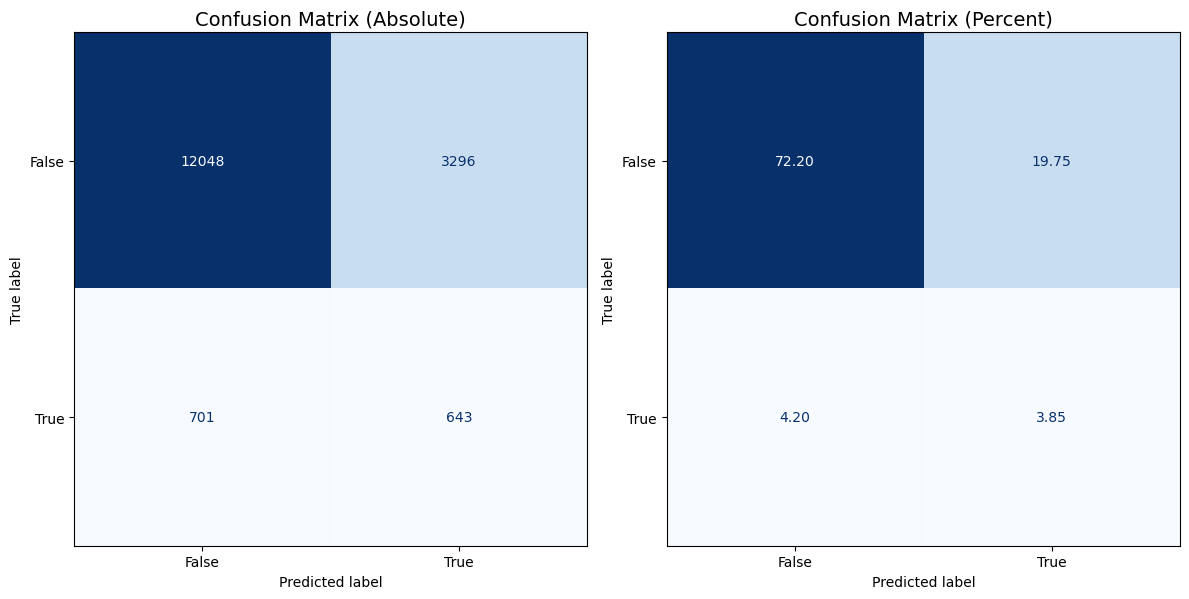

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, glm_pred)

# Calculate the percentage version of the confusion matrix
conf_matrix_percent_fixed = conf_matrix / conf_matrix.sum() * 100 

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Confusion matrix with absolute values
disp_abs = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=glm_optimized.classes_)
disp_abs.plot(ax=axes[0], cmap="Blues", values_format="d", colorbar=False)
axes[0].set_title("Confusion Matrix (Absolute)", fontsize=14)
axes[0].grid(False)

# Confusion matrix with percentages (formatted to 2 decimal places)
disp_percent_fixed = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percent_fixed, display_labels=glm_optimized.classes_)
disp_percent_fixed.plot(ax=axes[1], cmap="Blues", values_format=".2f", colorbar=False)
axes[1].set_title("Confusion Matrix (Percent)", fontsize=14)
axes[1].grid(False)
plt.tight_layout()
plt.show()

**Confusion Matrix (Absolute and Percentage):**

The confusion matrix analyzes the model's predictions in terms of true positives, false positives, true negatives, and false negatives.

**Absolute Matrix:**
- **True Negatives (TN):** 12,048 cases correctly classified as negative.
- **False Positives (FP):** 3,296 cases incorrectly classified as positive.
- **False Negatives (FN):** 701 cases incorrectly classified as negative.
- **True Positives (TP):** 643 cases correctly classified as positive.

**Percentage Matrix:**

Shows the same data in relative terms:
- TN: 72.20%, FP: 19.75%, FN: 4.20%, TP: 3.85%.
- A low percentage of true positives (TP) at 3.85% suggests that the model is struggling to correctly identify the positive class, which might require threshold adjustments or model improvements.

The model shows moderate performance (AUC = 0.7113), but the low percentage of true positives (TP) in the confusion matrix suggests that improvements could be made by adjusting the decision threshold, gathering more data, or experimenting with other more complex architectures/models.

### GLM Model Evaluation

The Generalized Linear Model (GLM) was chosen as the best model due to its strong performance metrics compared to other methods. It achieved an overall accuracy of 0.7606, but in an imbalanced problem like this, accuracy is not the most representative metric, as it is heavily influenced by the majority class. Metrics by class provide more insight.

For the majority class (0), the model had a precision of 0.9450 and a recall of 0.7853, indicating it correctly classifies most negative instances. However, for the minority class (1), the model's precision was 0.1633 and recall was 0.4784, reflecting significant false positives despite identifying 47.8% of true positive cases. The F1-score of 0.2435 for the minority class confirms the difficulty in balancing precision and recall for this class.

In practical terms, the GLM stands out for its simplicity, fast training, and interpretability, which is advantageous for projects requiring transparency. Techniques like regularization and class_weight adjustments helped mitigate class imbalance to some extent, but they did not substantially improve the minority class metrics.

While the GLM was the best among the evaluated models, the class imbalance remains a critical challenge. Despite using techniques like SMOTE and hyperparameter optimization, the model struggled to reduce false negatives or improve precision for the minority class.

In [ ]:
joblib.dump(glm_optimized, 'glm_optimized.pkl')

X_train_pca_df = pd.DataFrame(X_train_pca)
X_test_pca_df = pd.DataFrame(X_test_pca)
X_train_pca_df.to_csv(r'../content/X_train_pca.csv', index=False)
X_test_pca_df.to_csv(r'../content/X_test_pca.csv', index=False)

X_train_selected_df = pd.DataFrame(X_train_selected)
X_train_selected_df.to_csv(r'../content/X_train_selected.csv', index=False)

In this notebook, several algorithms were evaluated to address a classification problem with imbalanced data. Among the models tested, the GLM (Generalized Linear Model) stood out as the best in terms of balancing simplicity, interpretability, and performance. Although other models like XGBoost, LightGBM, and Random Forest showed high overall accuracy, they struggled significantly to predict the minority class (1).

The GLM achieved an overall accuracy of 0.7606 and a recall of 47.84% for class 1, outperforming other models in balanced metrics. While hyperparameter optimization using Grid Search and Randomized Search showed no significant improvements, the model proved to be robust from its initial configuration.

Despite its solid performance, the challenge of class imbalance persists, limiting the effective identification of the minority class. This suggests the need to explore additional techniques in future iterations to further optimize the prediction of this class.






